In [1]:
import os
import glob
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [2]:
# 啟用混合精度訓練
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [3]:
# 定義圖片大小與數據路徑
img_size = 128
lion_dir = r'C:\Users\Louis\Desktop\project\cnn-animals\data_augmented\lion'
leopard_dir = r'C:\Users\Louis\Desktop\project\cnn-animals\data_augmented\leopard'
categories = ['lion', 'leopard']

In [4]:
# 準備資料集
data = []
labels = []

In [5]:
# 加載圖像並進行預處理
def load_images_from_directory(directory, label):
    for img_path in glob.glob(os.path.join(directory, '*.jpg')):
        try:
            img_array = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
            img_array = tf.keras.preprocessing.image.img_to_array(img_array)
            data.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

In [6]:
# 獅子和豹的圖像加載
load_images_from_directory(lion_dir, 0)  # 獅子標籤為 0
load_images_from_directory(leopard_dir, 1)  # 豹標籤為 1

In [7]:
# 數據轉為 NumPy 陣列並進行標準化
data = np.array(data, dtype='float32') / 255.0
labels = np.array(labels)

In [8]:
# 將標籤轉為 one-hot 編碼
labels = tf.keras.utils.to_categorical(labels, num_classes=2)

In [9]:
# 分割訓練集、驗證集和測試集
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
# 顯示數據集大小
print(f"訓練集大小: {X_train.shape[0]} 張")
print(f"驗證集大小: {X_val.shape[0]} 張")
print(f"測試集大小: {X_test.shape[0]} 張")

訓練集大小: 4098 張
驗證集大小: 228 張
測試集大小: 228 張


In [11]:
model = Sequential()

In [26]:
# 啟用混合精度訓練
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [12]:
# 定義模型

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax', dtype='float32'))  # 保持輸出層為 float32


In [14]:
# 編譯模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# 顯示模型結構
model.summary(line_length=200)

Model: "sequential"
________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                                             Output Shape                                                                    Param #                       
 conv2d (Conv2D)                                                                          (None, 128, 128, 32)                                                            896                           
                                                                                                                                                                                                        
 batch_normalization (BatchNormalization)                                                 (None, 128, 128, 32)                                                            128   

In [16]:
# 設置回調函數
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
#early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [17]:
# 訓練模型
train_history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=2,
    callbacks=[checkpoint, reduce_lr]
)
    #callbacks=[checkpoint, early_stop, reduce_lr]

Epoch 1/10
129/129 - 16s - loss: 2.9162 - accuracy: 0.6767 - val_loss: 12.6732 - val_accuracy: 0.5614 - lr: 0.0010 - 16s/epoch - 127ms/step
Epoch 2/10
129/129 - 11s - loss: 0.9031 - accuracy: 0.7377 - val_loss: 2.2666 - val_accuracy: 0.3684 - lr: 0.0010 - 11s/epoch - 85ms/step
Epoch 3/10
129/129 - 11s - loss: 0.5364 - accuracy: 0.7892 - val_loss: 1.6631 - val_accuracy: 0.4868 - lr: 0.0010 - 11s/epoch - 86ms/step
Epoch 4/10
129/129 - 11s - loss: 0.3974 - accuracy: 0.8399 - val_loss: 0.5544 - val_accuracy: 0.7456 - lr: 0.0010 - 11s/epoch - 87ms/step
Epoch 5/10
129/129 - 11s - loss: 0.3925 - accuracy: 0.8455 - val_loss: 0.8231 - val_accuracy: 0.6272 - lr: 0.0010 - 11s/epoch - 86ms/step
Epoch 6/10
129/129 - 11s - loss: 0.3272 - accuracy: 0.8680 - val_loss: 0.2933 - val_accuracy: 0.8772 - lr: 0.0010 - 11s/epoch - 87ms/step
Epoch 7/10
129/129 - 11s - loss: 0.3176 - accuracy: 0.8716 - val_loss: 0.2275 - val_accuracy: 0.9298 - lr: 0.0010 - 11s/epoch - 87ms/step
Epoch 8/10
129/129 - 11s - loss:

In [94]:
import tensorflow as tf
from keras import backend as K

# 清除 TensorFlow backend 記憶體
K.clear_session()

# 清圖
from keras import backend as K
K.clear_session()
import gc
gc.collect()

21637

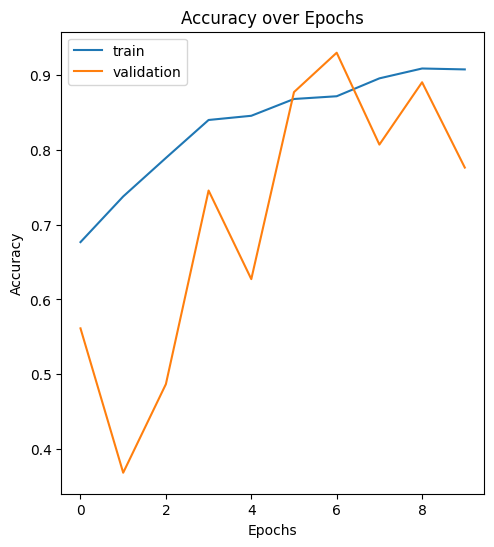

In [18]:
# 繪製準確率圖表
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_history.history['accuracy'], label='train')
plt.plot(train_history.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

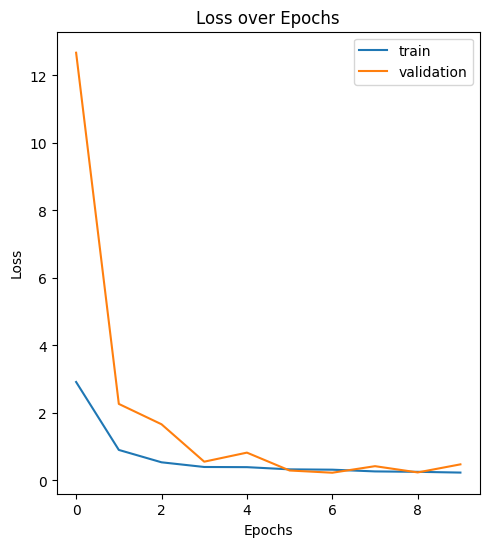

In [19]:
# 繪製損失率圖表
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_history.history['loss'], label='train')
plt.plot(train_history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

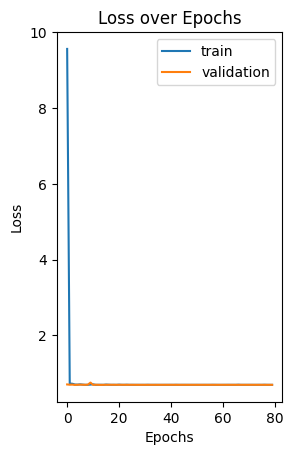

In [103]:
# 繪製損失率圖表
plt.subplot(1, 2, 2)
plt.plot(train_history.history['loss'], label='train')
plt.plot(train_history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [20]:
# 評估模型
scores = model.evaluate(X_test, y_test, verbose=0)
print('\n測試集準確率:', scores[1])
print('測試集損失率:', scores[0])


測試集準確率: 0.7675438523292542
測試集損失率: 0.6062317490577698


8/8 [==============================] - 0s 25ms/step


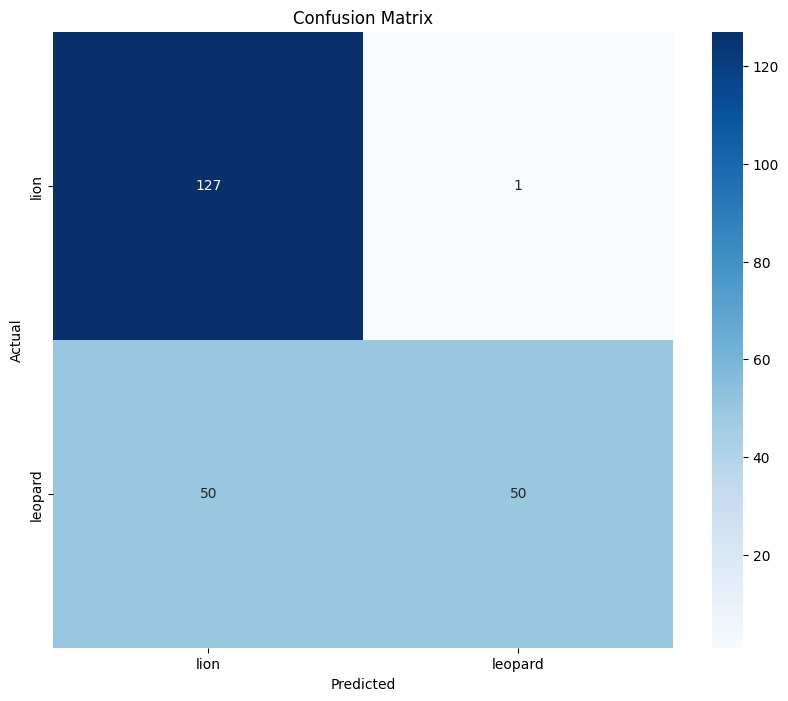

In [21]:
# 預測並繪製混淆矩陣
val_predictions = model.predict(X_val)
val_predicted_classes = np.argmax(val_predictions, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

conf_mat = confusion_matrix(y_val_classes, val_predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

8/8 [==============================] - 0s 31ms/step


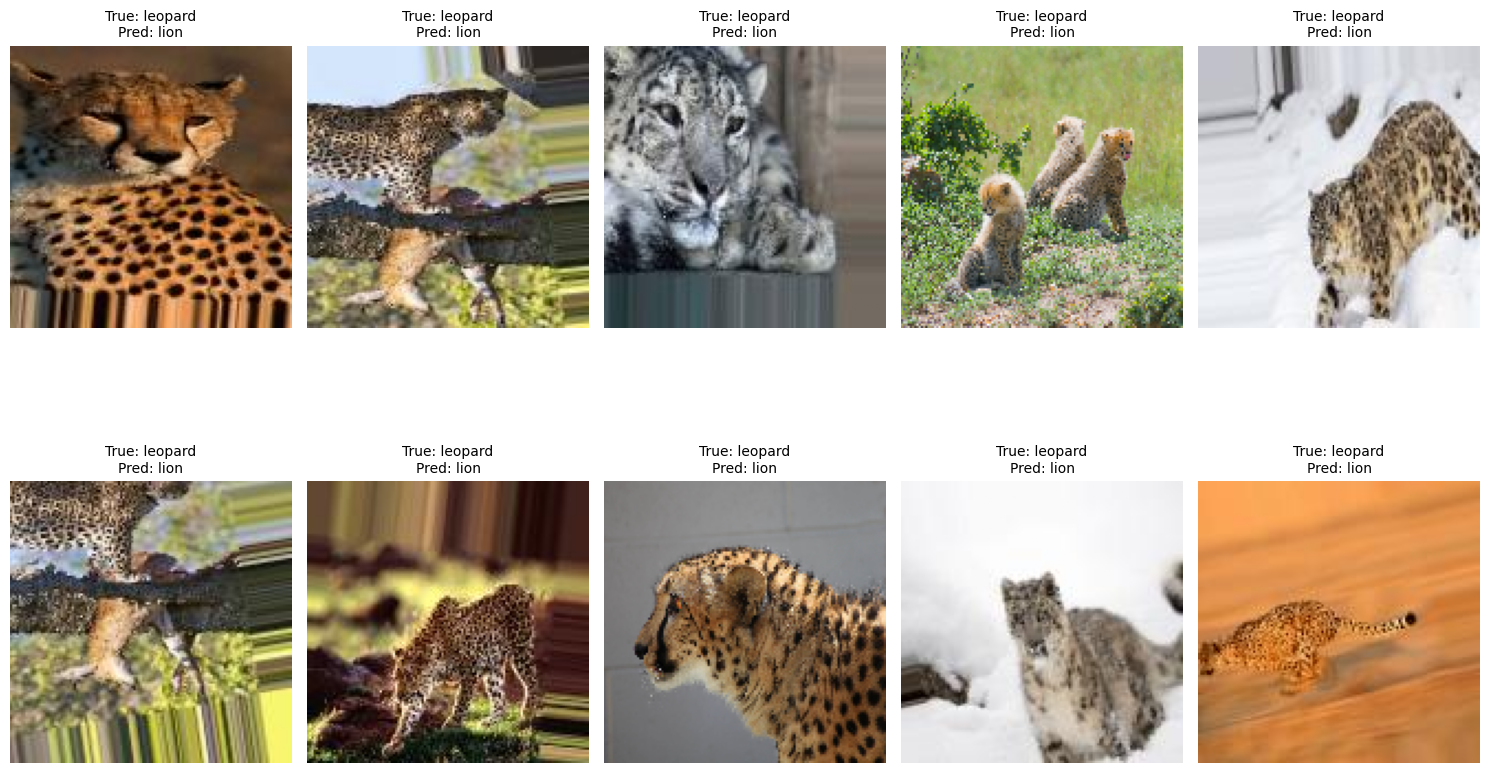

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# 預測
val_predictions = model.predict(X_val)
val_predicted_classes = np.argmax(val_predictions, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# 抓出預測錯誤的 index
wrong_indices = np.where(val_predicted_classes != y_val_classes)[0]

# 顯示前 10 張錯誤圖片
plt.figure(figsize=(15, 10))
for i, idx in enumerate(wrong_indices[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_val[idx])
    true_label = categories[y_val_classes[idx]]
    pred_label = categories[val_predicted_classes[idx]]
    plt.title(f'True: {true_label}\nPred: {pred_label}', fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [106]:
# 顯示分類報告
report = classification_report(y_val_classes, val_predicted_classes, target_names=categories)
print(report)

              precision    recall  f1-score   support

        lion       0.00      0.00      0.00       128
     leopard       0.44      1.00      0.61       100

    accuracy                           0.44       228
   macro avg       0.22      0.50      0.30       228
weighted avg       0.19      0.44      0.27       228



c:\Users\Louis\Desktop\project\cnn-animals\.venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Louis\Desktop\project\cnn-animals\.venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Louis\Desktop\project\cnn-animals\.venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [93]:
# 取出最終 epoch 的準確率與驗證準確率
final_train_acc = train_history.history['accuracy'][-1]
final_val_acc = train_history.history['val_accuracy'][-1]

print(f"最終訓練準確率：{final_train_acc:.4f}")
print(f"最終驗證準確率：{final_val_acc:.4f}")

最終訓練準確率：0.9995
最終驗證準確率：0.9781
